In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Génération de données simulées pour le méta-dataset
def generate_meta_dataset(n_datasets=500, n_features=5):
    meta_features = []
    optimal_params = []
    for _ in range(n_datasets):
        X = np.random.rand(100, n_features)
        true_coefficients = np.random.uniform(0.5, 2.0, size=n_features)
        true_b = np.random.uniform(0.5, 2.0)
        y = np.dot(X, true_coefficients) + true_b + np.random.normal(0, 0.1, size=100)
        meta = extract_meta_features_multi(pd.DataFrame(X), y)
        meta_features.append(meta.iloc[:-1, 1:].values.flatten())  # Enlever les noms des colonnes
        optimal_params.append(np.append(true_coefficients, true_b))  # Coefficients + biais
    return np.array(meta_features), np.array(optimal_params)

In [3]:
# Extraire les méta-caractéristiques d'un dataset
def extract_meta_features_multi(X, y):
    meta_features = []
    for col in X.columns:
        x_col = X[col]
        meta_features.append({
            'Feature': col,
            'mean': np.mean(x_col),
            'std': np.std(x_col),
            'range': np.max(x_col) - np.min(x_col),
            'skew': np.mean(((x_col - np.mean(x_col)) / np.std(x_col))**3),
            'correlation_with_y': np.corrcoef(x_col, y)[0, 1]
        })
    meta_features.append({
        'Feature': 'y',
        'mean': np.mean(y),
        'std': np.std(y),
        'range': np.max(y) - np.min(y),
        'skew': np.mean(((y - np.mean(y)) / np.std(y))**3),
        'correlation_with_y': None
    })
    return pd.DataFrame(meta_features)

In [4]:
# Classe AdvancedMetaLearner
class AdvancedMetaLearner:
    def __init__(self, model_type='rf', n_features=5):
        self.model_type = model_type
        self.n_features = n_features
        self.scaler = StandardScaler()
        self.models = []
        if model_type == 'rf':
            for _ in range(n_features + 1):  # Un modèle pour chaque coefficient + biais
                self.models.append(RandomForestRegressor(n_estimators=100, max_depth=10))
        elif model_type == 'svr':
            for _ in range(n_features + 1):
                self.models.append(SVR(kernel='rbf', C=1.0, epsilon=0.1))

    def train(self, meta_features, optimal_params):
        X_scaled = self.scaler.fit_transform(meta_features)
        for i in range(self.n_features + 1):
            self.models[i].fit(X_scaled, optimal_params[:, i])

    def predict(self, meta_features):
        X_scaled = self.scaler.transform(meta_features.reshape(1, -1))
        predictions = []
        for i in range(self.n_features + 1):
            pred = self.models[i].predict(X_scaled)[0]
            predictions.append(pred)
        return predictions

In [5]:
# Générer un nouveau dataset
def generate_dataset(n_features=5, true_coefficients=None, true_b=None):
    if true_coefficients is None:
        true_coefficients = np.random.uniform(0.5, 2.0, size=n_features)
    if true_b is None:
        true_b = np.random.uniform(0.5, 2.0)
    X = np.random.rand(100, n_features)
    y = np.dot(X, true_coefficients) + true_b + np.random.normal(0, 0.1, size=100)
    return X, y

In [6]:
# Évaluation du système de méta-apprentissage
def evaluate_meta_learning_system():
    # Générer le méta-dataset
    meta_features, optimal_params = generate_meta_dataset(n_datasets=500, n_features=5)

    # Split train/validation
    X_train, X_val, y_train, y_val = train_test_split(
        meta_features, optimal_params, test_size=0.2, random_state=42
    )

    # Entraîner les méta-learners
    rf_meta_learner = AdvancedMetaLearner(model_type='rf', n_features=5)
    svr_meta_learner = AdvancedMetaLearner(model_type='svr', n_features=5)
    rf_meta_learner.train(X_train, y_train)
    svr_meta_learner.train(X_train, y_train)

    # Tester sur un nouveau dataset
    X_test, y_test = generate_dataset(
        n_features=5,
        true_coefficients=[1.0, 2.0, 3.0, 4.0, 5.0],
        true_b=1.5
    )

    # Extraire les méta-features du test
    meta_dict = extract_meta_features_multi(pd.DataFrame(X_test), y_test)
    combined_features = []
    for feature_name in sorted(meta_dict['Feature'][:-1]):
        combined_features.extend(meta_dict.loc[meta_dict['Feature'] == feature_name].iloc[:, 1:].values.flatten())
    test_meta_features = np.array(combined_features)

    # Obtenir les initialisations prédites
    predictions_rf = rf_meta_learner.predict(test_meta_features)
    predictions_svr = svr_meta_learner.predict(test_meta_features)

    return (X_test, y_test,
            predictions_rf[:-1], predictions_rf[-1],
            predictions_svr[:-1], predictions_svr[-1])

In [7]:
# Fonction de descente de gradient pour la régression linéaire
def train_linear_regression(X, y, coefficients_init, b_init, epochs=500, learning_rate=0.005):
    # Initialisation des coefficients pour chaque feature
    coefficients = coefficients_init  # [a1, a2, a3, ..., an]
    b = b_init
    losses = []

    # Descente de gradient
    for i in range(epochs):
        # Prédiction: y = a1*x1 + a2*x2 + ... + an*xn + b
        y_pred = np.dot(X, coefficients) + b

        # Calcul de l'erreur quadratique moyenne
        loss = np.mean((y - y_pred)**2)
        losses.append(loss)

        # Calcul des gradients pour chaque coefficient
        D_coefficients = -2 * np.mean(X * (y - y_pred)[:, np.newaxis], axis=0)
        Db = -2 * np.mean(y - y_pred)

        # Mise à jour des coefficients et du biais
        coefficients = coefficients - learning_rate * D_coefficients
        b = b - learning_rate * Db

    return coefficients, b, losses

In [8]:

# Comparaison des approches
X_test, y_test, a_rf, b_rf, a_svr, b_svr = evaluate_meta_learning_system()


In [9]:
# Initialisation aléatoire
random_coefficients = np.random.rand(X_test.shape[1])
random_bias = np.random.rand()

=== Initialisations ===

Initialisation aléatoire :
Coefficients initiaux : [0.8398028  0.59680803 0.93462175 0.56647617 0.08166479]
Biais initial : 0.3711788147139168

Initialisation par Random Forest :
Coefficients initiaux : [0.9538235947227613, 1.2074799533642797, 1.4453887899859819, 1.489689730373867, 1.409346330610676]
Biais initial : 1.1256199970238425

Initialisation par SVR :
Coefficients initiaux : [0.8191994767576561, 1.0093295066252206, 1.0447556886175853, 1.1937384242698292, 1.3654474724860228]
Biais initial : 1.366653075538478

=== Résultats après descente de gradient ===

Résultats avec initialisation aléatoire :
Coefficients finaux : [2.02922666 2.153312   2.48806702 2.38703725 2.35234312]
Biais final : 3.2458426873985684

Résultats avec initialisation par Random Forest :
Coefficients finaux : [1.72123179 2.17094047 2.49070513 2.69892241 2.97165262]
Biais final : 2.9378766976234307

Résultats avec initialisation par SVR :
Coefficients finaux : [1.66499043 2.09207739 2.2

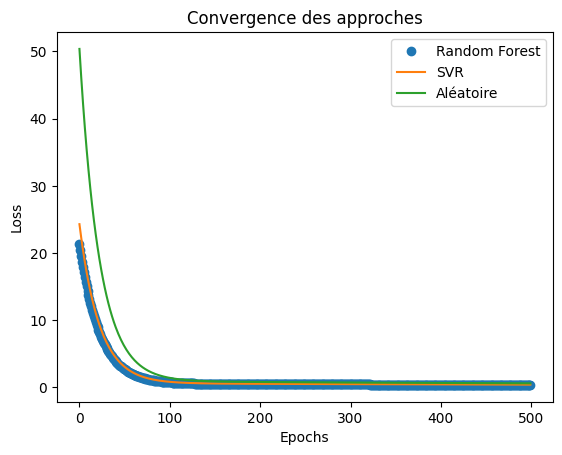

In [10]:
print("=== Initialisations ===")
print("\nInitialisation aléatoire :")
print("Coefficients initiaux :", random_coefficients)
print("Biais initial :", random_bias)

print("\nInitialisation par Random Forest :")
print("Coefficients initiaux :", a_rf)
print("Biais initial :", b_rf)

print("\nInitialisation par SVR :")
print("Coefficients initiaux :", a_svr)
print("Biais initial :", b_svr)

# Entraînement avec descente de gradient
coeff_rf, bias_rf, losses_rf = train_linear_regression(X_test, y_test, a_rf, b_rf)
coeff_svr, bias_svr, losses_svr = train_linear_regression(X_test, y_test, a_svr, b_svr)
coeff_rand, bias_rand, losses_rand = train_linear_regression(X_test, y_test, random_coefficients, random_bias)

# Résultats finaux
print("\n=== Résultats après descente de gradient ===")
print("\nRésultats avec initialisation aléatoire :")
print("Coefficients finaux :", coeff_rand)
print("Biais final :", bias_rand)

print("\nRésultats avec initialisation par Random Forest :")
print("Coefficients finaux :", coeff_rf)
print("Biais final :", bias_rf)

print("\nRésultats avec initialisation par SVR :")
print("Coefficients finaux :", coeff_svr)
print("Biais final :", bias_svr)

# Courbes de convergence
plt.plot(losses_rf, 'o' , label="Random Forest")
plt.plot(losses_svr, label="SVR")
plt.plot(losses_rand, label="Aléatoire")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Convergence des approches")
plt.show()

Augmentation de dataset